In [65]:
%load_ext autoreload
%autoreload 2

from ff_energy.simulations import charmm, plots
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
from pint import UnitRegistry
import warnings

# ignore the casting errors for units
warnings.simplefilter("ignore")
ureg = UnitRegistry()

#  matplotlib styles
plt.style.use(["science", "no-latex", "ieee"])

#  constants
Avogadro_const = 6.02214129 * 10**23 * ureg("mol^-1")  # % mol-1

def get_density(volume, N_res, MW):
    """
    get the density of the simulation for a given volume, number of molecules and
    molecular weight :param volume: m^3 :param N_res: number :param MW: g/mol
    :return: density in g/m^3
    """
    MW = MW * ureg("g/mol")

    return N_res * MW / (Avogadro_const * volume)

In [67]:
get_density(40.2**3, 900, 32 * ureg("g/mol"))

7.361450360282303e-25 <Unit('gram ** 2 / mole')>

In [68]:
v = 57000 * ureg("angstrom^3")

get_density(v, 2000, 18 * ureg("g/mol"))

1.0487614238098042e-24 <Unit('gram ** 2 / angstrom ** 3 / mole')>

In [69]:
# jobpath = "/home/boittier/pcbach/mdcm_water_sim/dynamics.log"
# jobpath = "/home/boittier/pcbach/kmdcm_nn_water1.2/kmdcm-dynamics.log"
# jobpath = "/home/boittier/pcbehome/kmdcm_nn_water1/kmdcm-dynamics.log"
# jobpath = "/home/boittier/homepcb/kmdcm_nn_water1/dynamics.nve.prod.log"
# jobpath = "/home/boittier/pcbach/kmdcm_water_sim_rkhs1/dynamics.log"
jobpath = "/home/boittier/pcbach/kmdcm_water_sim_rkhs2/dynamics.log"
# jobpath = "/home/boittier/pcbach/shake/dynamics_restart_nve"


# jobpath = "/home/boittier/pcbach/water_sim_rkhs/dynamics.log"
cl = charmm.read_charmm_log(jobpath)

IndexError: list index out of range

TypeError: no numeric data to plot

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times


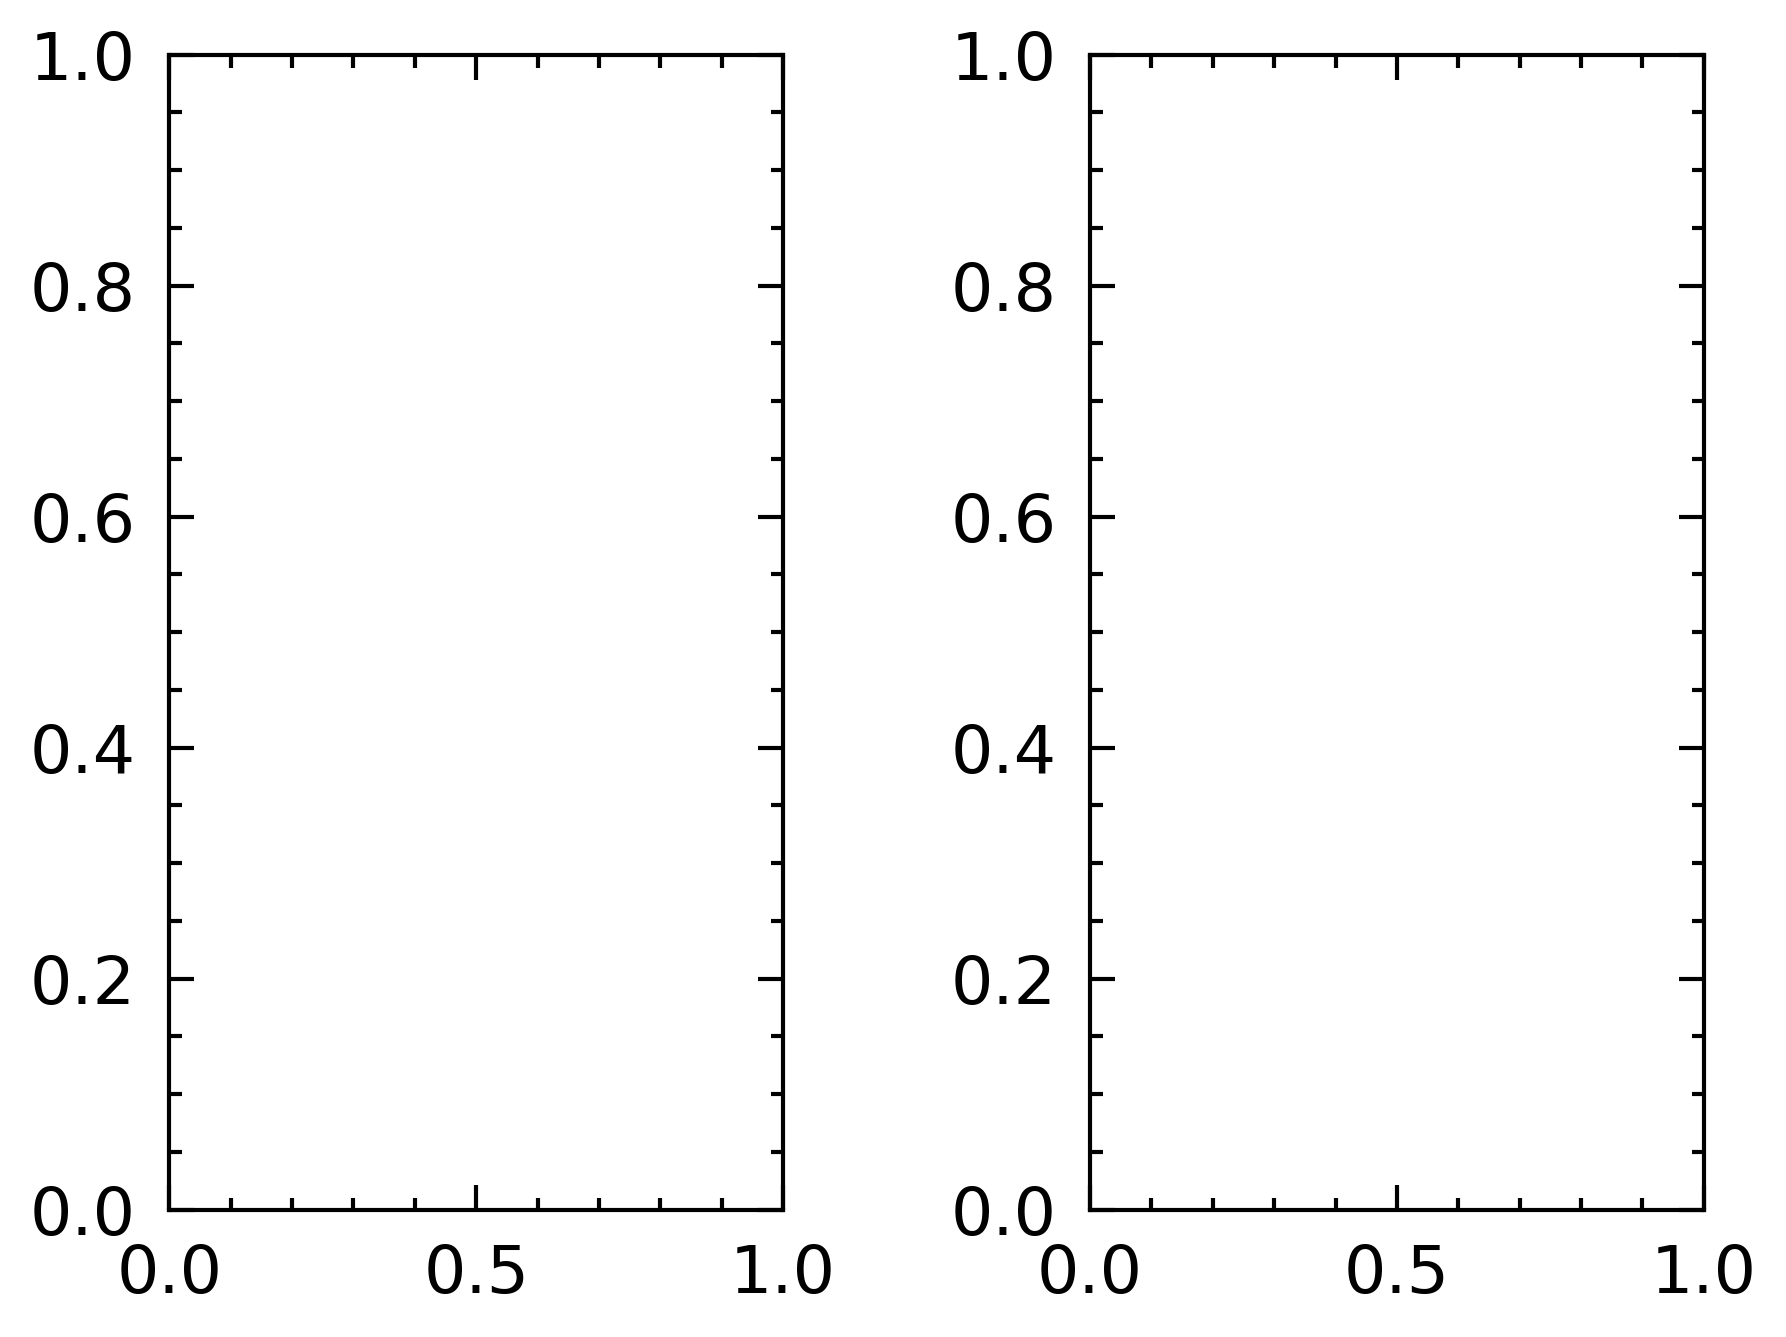

In [62]:
fig, axes = plt.subplots(1,2)
plt.subplots_adjust(wspace=0.5)

# vals = cl["tot"].iloc[-1000000:].dropna() 
# vals = cl["tot"].iloc[-5000:].dropna() 
vals = cl["tot"].iloc[:].dropna() 
(vals - vals.mean()).plot(ax=axes[0])
(vals - vals.mean()).rolling(500).mean().plot(ax=axes[0])
(vals - vals.mean()).hist(ax=axes[1])
axes[0].set_xlabel("Time [t]")
axes[0].set_ylabel("Var($E$) [kcal/mol]")
axes[1].set_ylabel("Count")
axes[1].set_xlabel("Var($E$) [kcal/mol]")

In [63]:
# plt.plot(range(len(cl)), (cl["tot"].dropna() - cl["tot"].mean()))

In [64]:
plots.make_plots(cl)

plotting
[]


IndexError: single positional indexer is out-of-bounds

In [61]:
from ase.visualize import view
import MDAnalysis as mda
from MDAnalysis.coordinates.XYZ import XYZWriter as XYZWriter
from ase import Atoms
import numpy as np

In [716]:
# fn = "water.2000.heat.dcd"
fn = "water.2000.prod.1.dcd"
from pathlib import Path

jobpath = "/home/boittier/pcbehome/kmdcm_nn_water1/kmdcm-dynamics.log"
jobpath = "/home/boittier/pcbach/kmdcm_water_sim_rkhs/dynamics.log"

dcdpath = Path(jobpath).parents[0] / fn
psfpath = Path(jobpath).parents[0] / "water.2000.psf"

# jobpath = "/home/boittier/pcbach/shake/dynamics.log"
jobpath = "/home/boittier/pcbach//sims/shake/water/k300/dynamics.log"

fn = "water.2000.dyna.59.dcd"
dcdpath = Path(jobpath).parents[0] / fn
psfpath = Path(jobpath).parents[0] / "water.2000.psf"

jobpath = "/home/boittier/pcbach/kmdcm_water_sim_rkhs1/dynamics.log"
fn = "water.2000.prod.1.dcd"
dcdpath = Path(jobpath).parents[0] / fn
psfpath = Path(jobpath).parents[0] / "water.2000.psf"


In [717]:
# filepath

In [718]:
u = mda.Universe(psfpath, dcdpath)

In [719]:
type(u._topology)
u.trajectory

<DCDReader /home/boittier/pcbach/kmdcm_water_sim_rkhs1/water.2000.prod.1.dcd with 1940 frames of 6000 atoms>

In [721]:
"{} {} {}".format(*u.trajectory[0].dimensions[:3])

'37.985862731933594 37.985862731933594 37.985862731933594'

In [90]:
for i, ts in enumerate(u.trajectory[::10]):
    with XYZWriter(f'shake{i}.xyz', remark="{} {} {}".format(*ts.dimensions[:3])) as w:
        w.write(u)

In [263]:
atoms = u.select_atoms("all")
# for _ in u.trajectory[::100]:
    
def get_ase_atoms(u):
    ase_atoms = Atoms(atoms.masses, atoms.positions, cell = u.dimensions)
    Z = np.tile(np.array([8, 1, 1]), 2000)
    ase_atoms.set_atomic_numbers(Z)
    ase_atoms.set_cell(u.dimensions)
    mid = ase_atoms.get_cell()/2
    ase_atoms.translate(mid.diagonal())
    return ase_atoms

def plot_atoms(u, ax):
    ase_atoms = get_ase_atoms(u)
    write('image.png', ase_atoms,rotation='80z,-80x')
    img = np.asarray(Image.open('image.png'))
    imgplot = ax.imshow(img)
    return ax, ase_atoms

In [264]:
atoms

<AtomGroup with 6000 atoms>

In [265]:
ATOMS = []
for _ in u.trajectory:
    # print(_)
    ATOMS.append(get_ase_atoms(u))

In [266]:
# print(ATOMS)

In [267]:
from ase import Atoms
from ase.geometry import find_mic
import ase.io
from typing import List

def unwrap(frames: List[Atoms], initial_reference: Atoms=None) -> List[Atoms]:
    """Modifies ``frames`` in-place."""
    if initial_reference is not None:
        ref_frame = initial_reference
    else:
        ref_frame = frames[0]
        frames = frames[1:]

    for frame in frames:
        ref_cart_coords = ref_frame.positions
        cart_coords = frame.positions
        cart_diff, _ = find_mic(cart_coords-ref_cart_coords, cell=frame.cell)
        new_cart_coords = ref_cart_coords + cart_diff
        frame.positions[:] = new_cart_coords
        ref_frame = frame
        

unwrap(ATOMS, initial_reference = ATOMS[0])

In [268]:
from msd import DiffusionCoefficient

In [269]:
dc = DiffusionCoefficient(ATOMS, 1000 * 0.002)

In [270]:
dc.calculate()

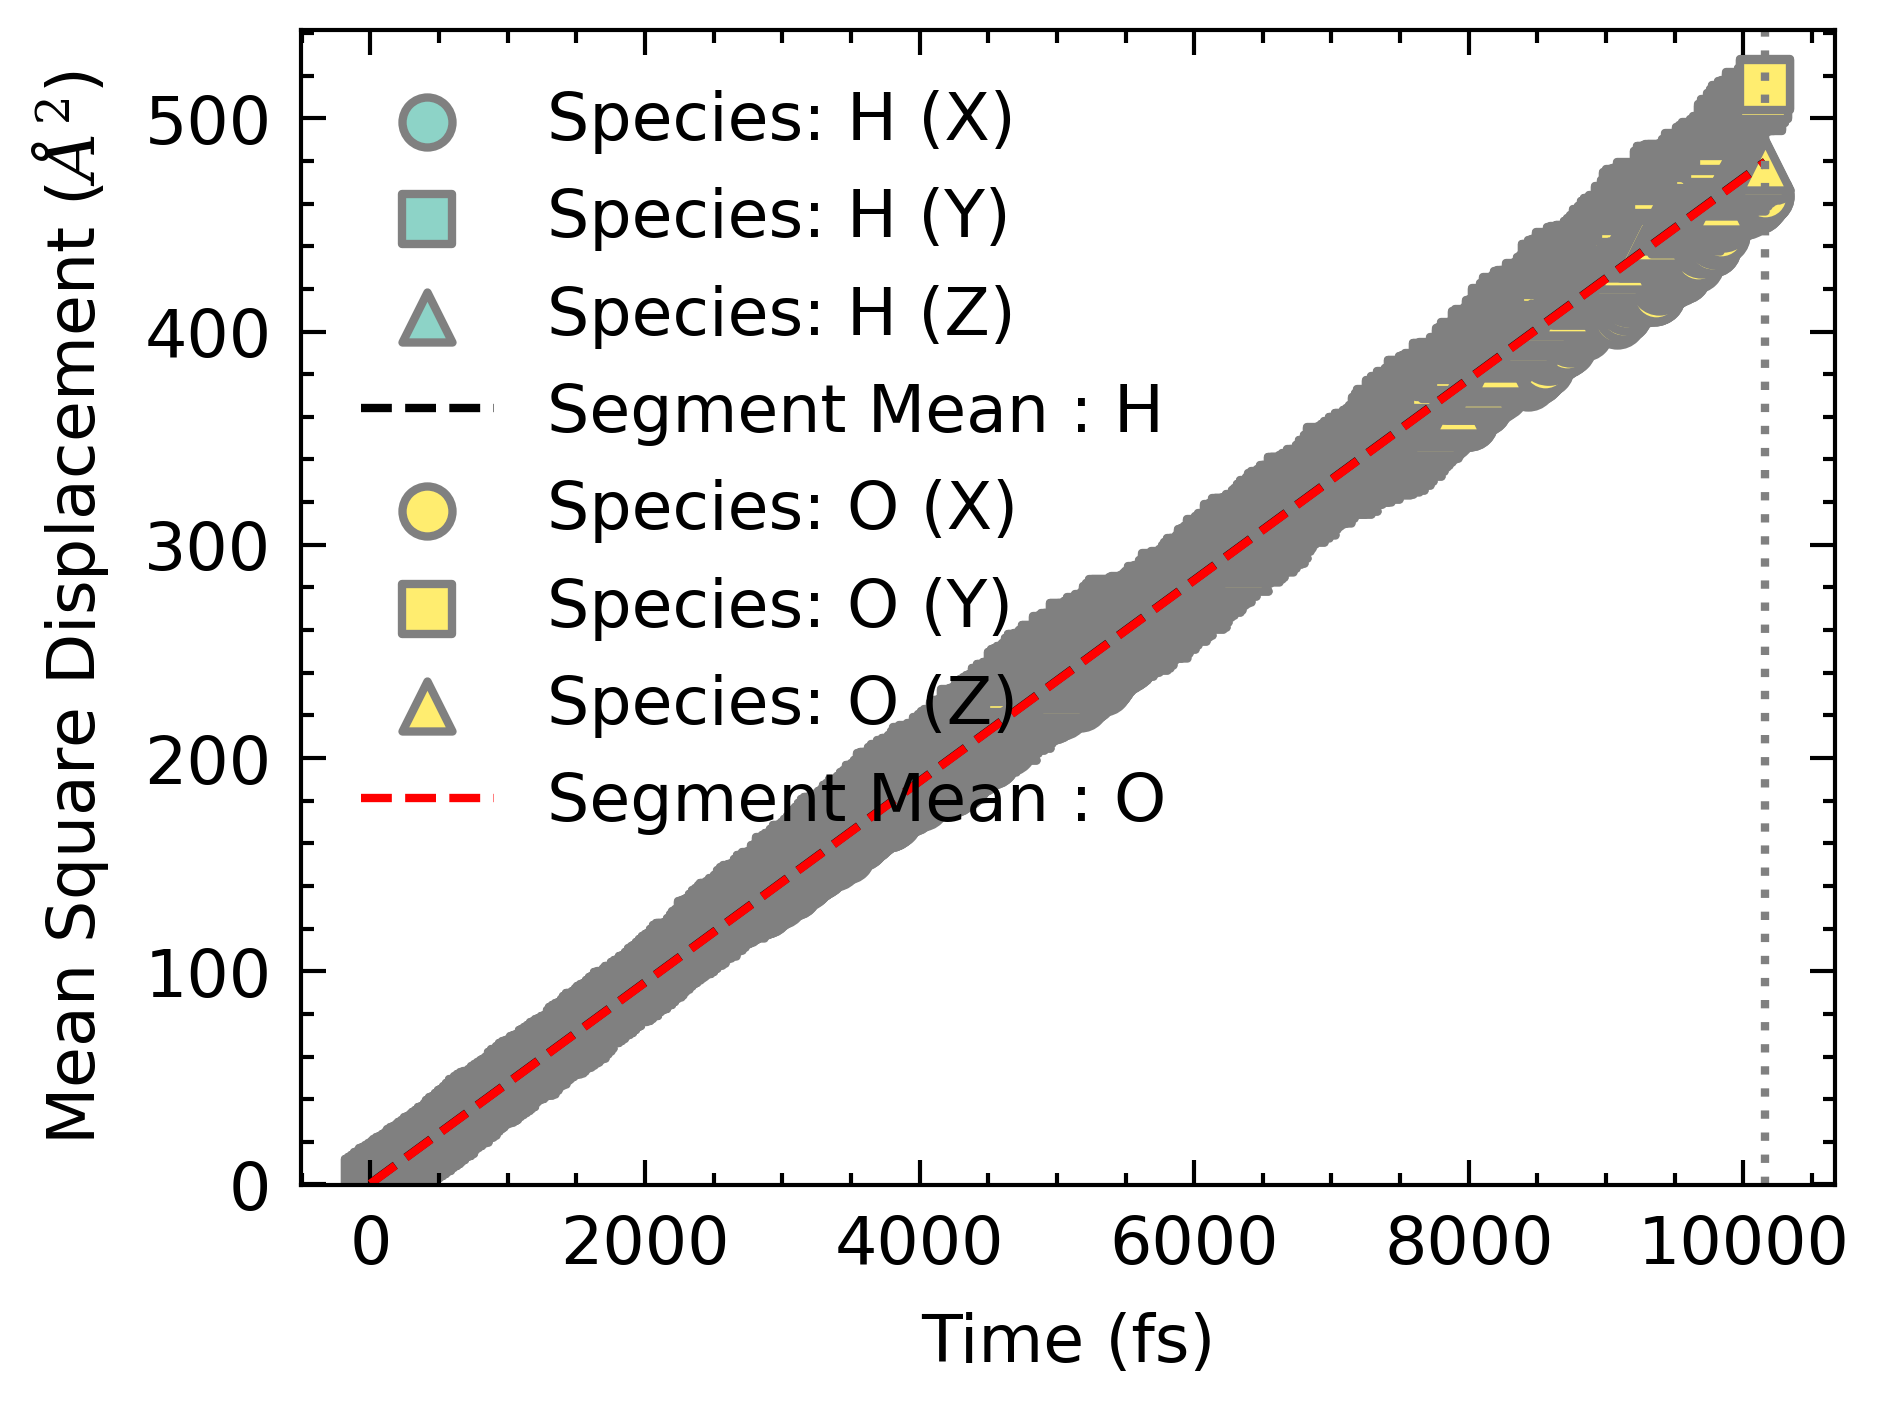

In [271]:
dc.plot()

In [272]:
dc.print_data()

---
Species:    H
---
Segment     0:         Diffusion Coefficient = 0.0471678360 Å^2/fs; Intercept = 0.4921670495 Å^2;
---
Species:    O
---
Segment     0:         Diffusion Coefficient = 0.0471622475 Å^2/fs; Intercept = 0.3376041044 Å^2;
---
Mean Diffusion Coefficient (X, Y and Z) : H = 0.0471678360 Å^2/fs; Std. Dev. = 0.0018811664 Å^2/fs
Mean Diffusion Coefficient (X, Y and Z) : O = 0.0471622475 Å^2/fs; Std. Dev. = 0.0018638005 Å^2/fs
---


In [273]:
0.0471622475 * 10**-5 

4.71622475e-07

In [722]:
import MDAnalysis.analysis.msd as msd

# transform = mda.transformations.unwrap(ag)
# u.trajectory.add_transformations(transform)

MSD = msd.EinsteinMSD(u, select='type OT', msd_type='xyz', fft=True)
MSD.run(0, -1)

In [723]:
# u.__dict__

In [724]:
msd =  MSD.results.timeseries

In [725]:
# msd

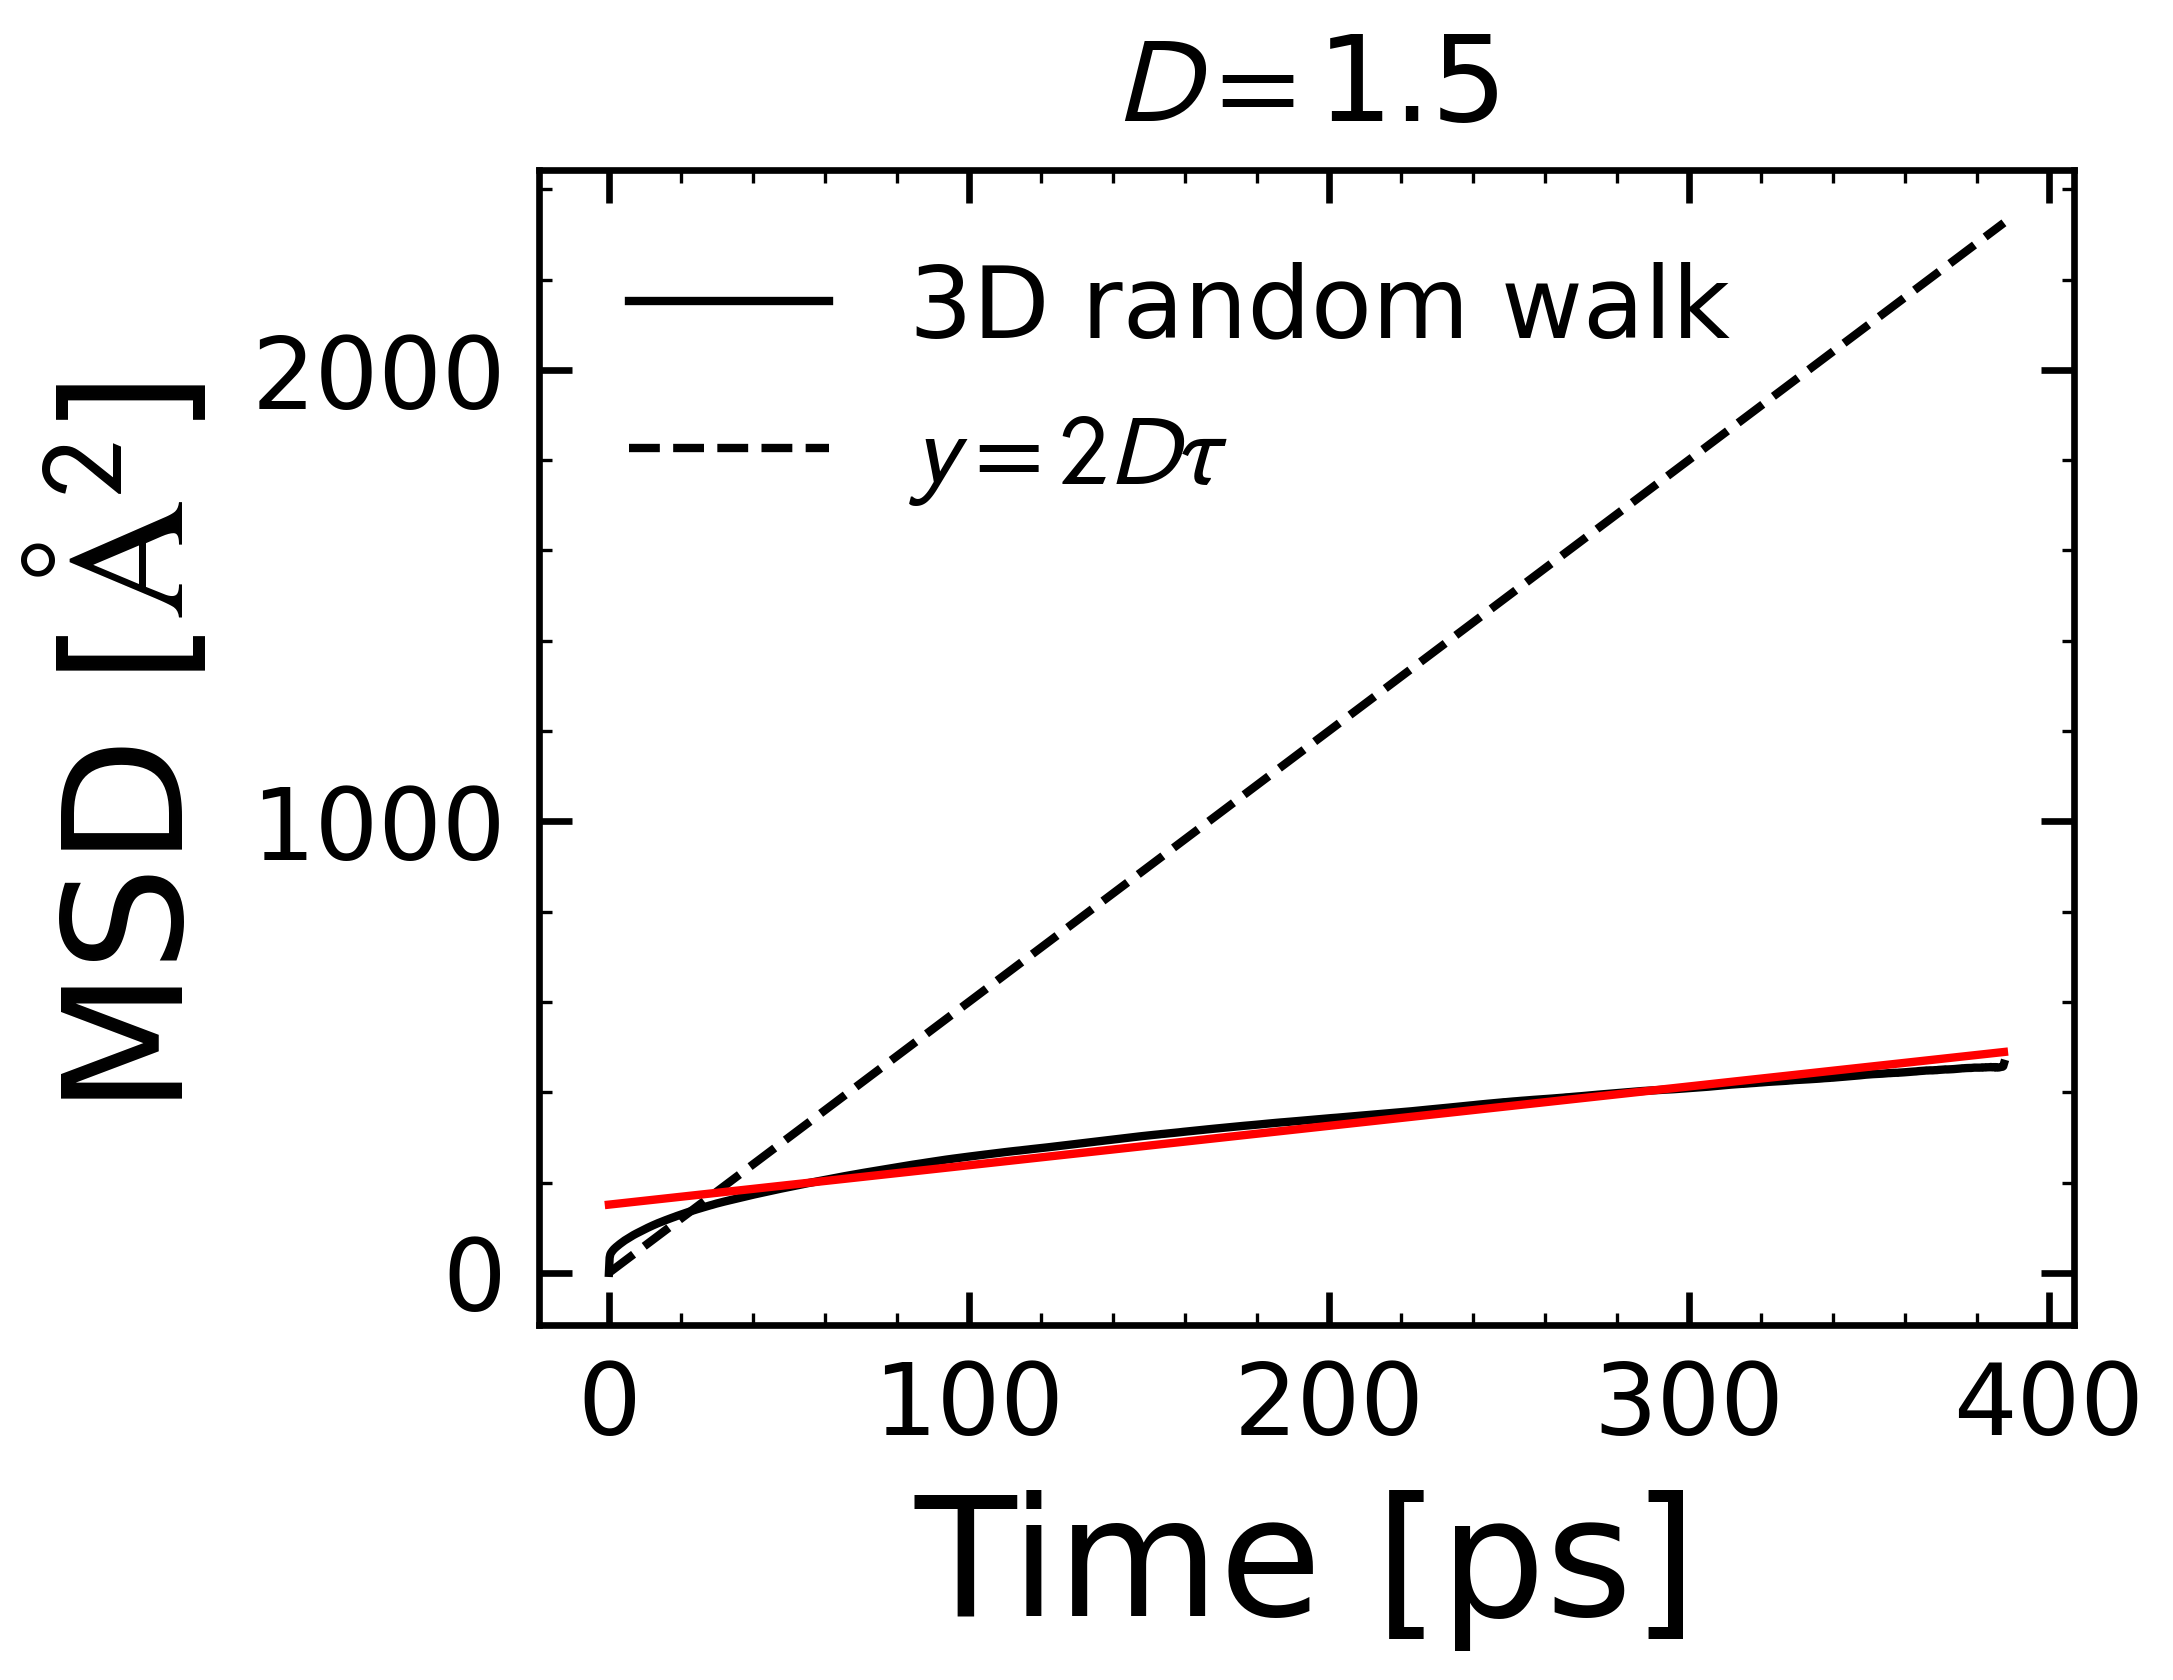

In [734]:
import matplotlib.pyplot as plt
nframes = MSD.n_frames
timestep = 1000 * 0.0002 # this needs to be the actual time between frames
# timestep = 1000 * 0.002 # this needs to be the actual time between frames
# timestep = 10000 * 0.0002
lagtimes = np.arange(nframes)*timestep # make the lag-time axis
fig = plt.figure()
ax = plt.axes()
# plot the actual MSD
ax.plot(lagtimes, msd, c="black", ls="-", label=r'3D random walk')
exact = lagtimes*6
# plot the exact result

ax.plot(lagtimes, exact, c="black", ls="--", label=r'$y=2 D\tau$')

plt.legend()
plt.xlabel("Time [ps]", fontsize=20)
plt.ylabel("MSD [$\mathrm{\AA}^{2}$]", fontsize=20)

from scipy.stats import linregress
start_time = 0
start_index = int(start_time/timestep)
end_index = -1
# end_time = 
linear_model = linregress(lagtimes[start_index:end_index],
                                              msd[start_index:end_index])
slope = linear_model.slope
error = linear_model.rvalue
# dim_fac is 3 as we computed a 3D msd with 'xyz'
D = slope * 1/(2*MSD.dim_fac)

plt.plot(lagtimes, lagtimes*slope + linear_model.intercept, c="r")

plt.title(f"$D = ${D / 0.1 :.1f}")

plt.savefig("msd_water_nn.pdf")
plt.show()


1.6344886411480086

In [366]:
atoms.masses

array([15.9994,  1.008 ,  1.008 , ..., 15.9994,  1.008 ,  1.008 ])

In [367]:
from ase import Atoms

In [145]:
# view(ase_atoms, viewer="x3d")
# import nglview as nv

In [146]:
import numpy as np

# ase_atoms.set_center_of_mass(u.dimensions[:3]/2)

In [ ]:
mid = ase_atoms.get_cell()/2
# ase_atoms.translate(mid)
mid.diagonal()

In [ ]:
from ase.io import write


In [ ]:
from PIL import Image

In [67]:
# ATOMS

In [ ]:
u.dimensions

<AxesSubplot:>

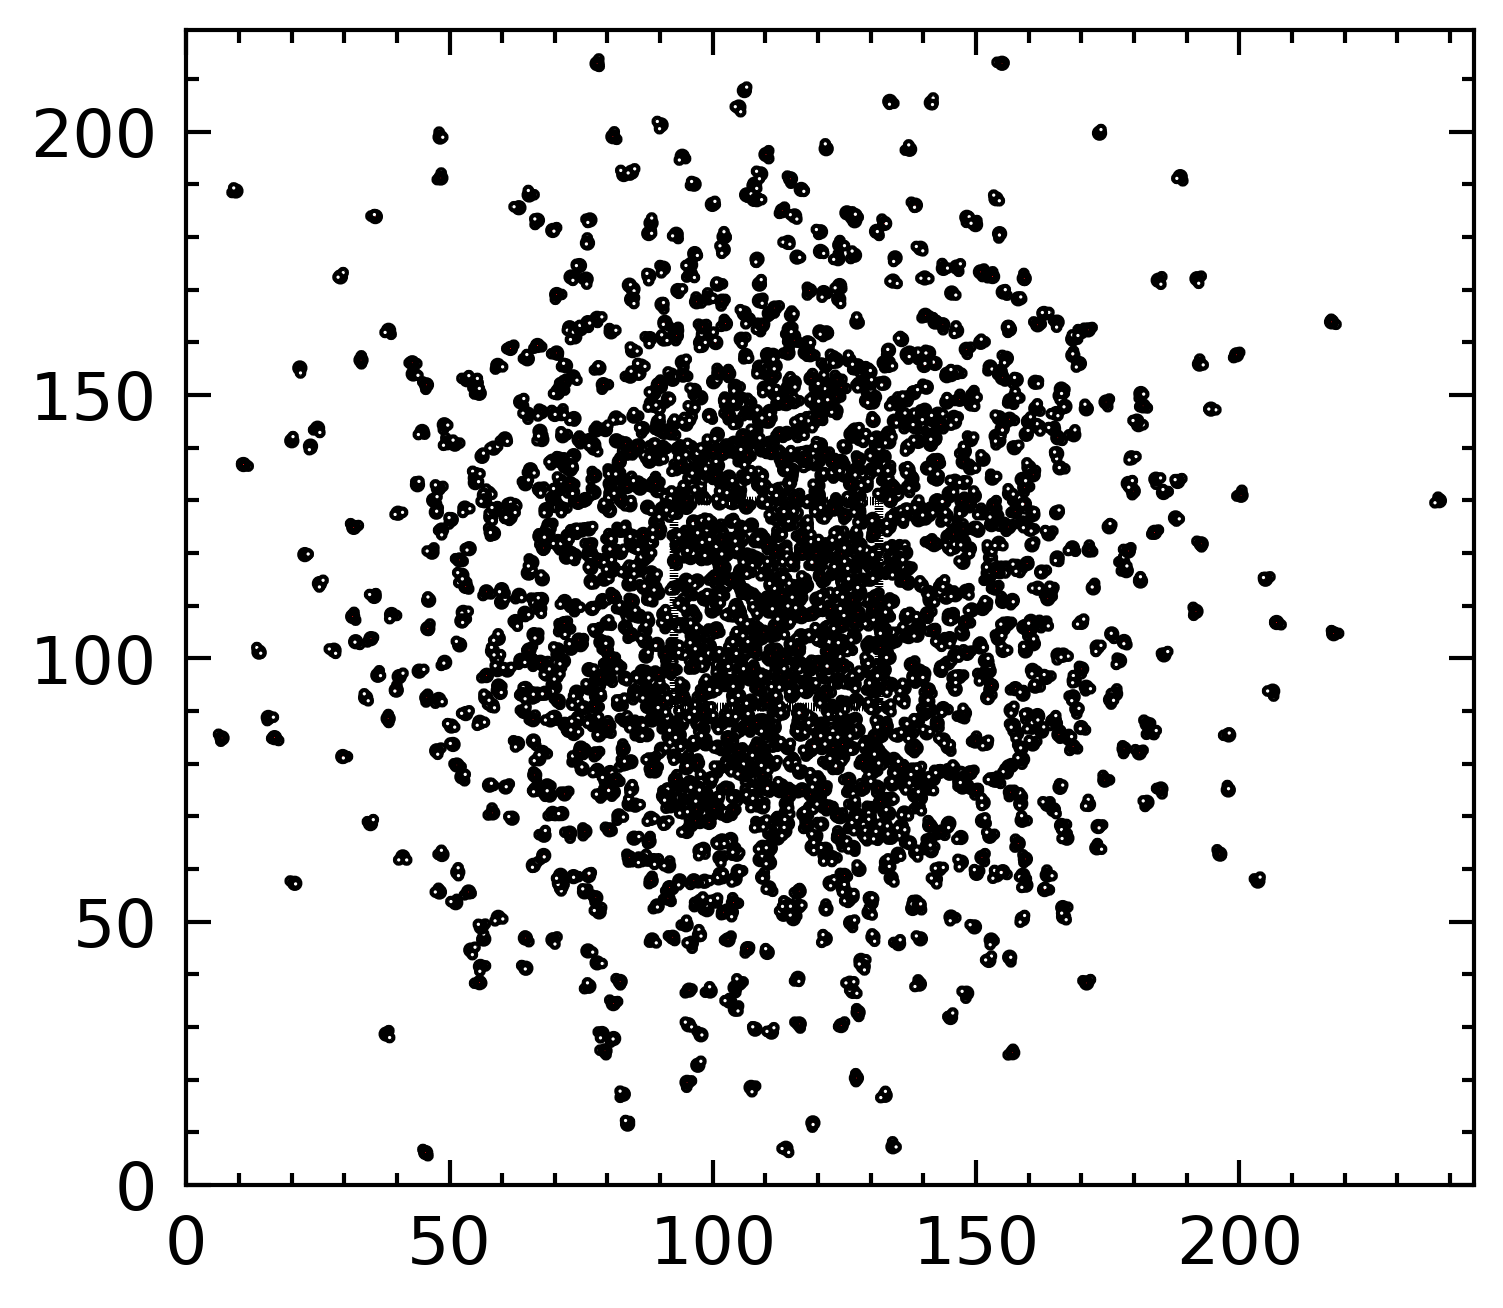

In [274]:
from ase.visualize.plot import plot_atoms

plot_atoms(ATOMS[-1])

<AxesSubplot:>

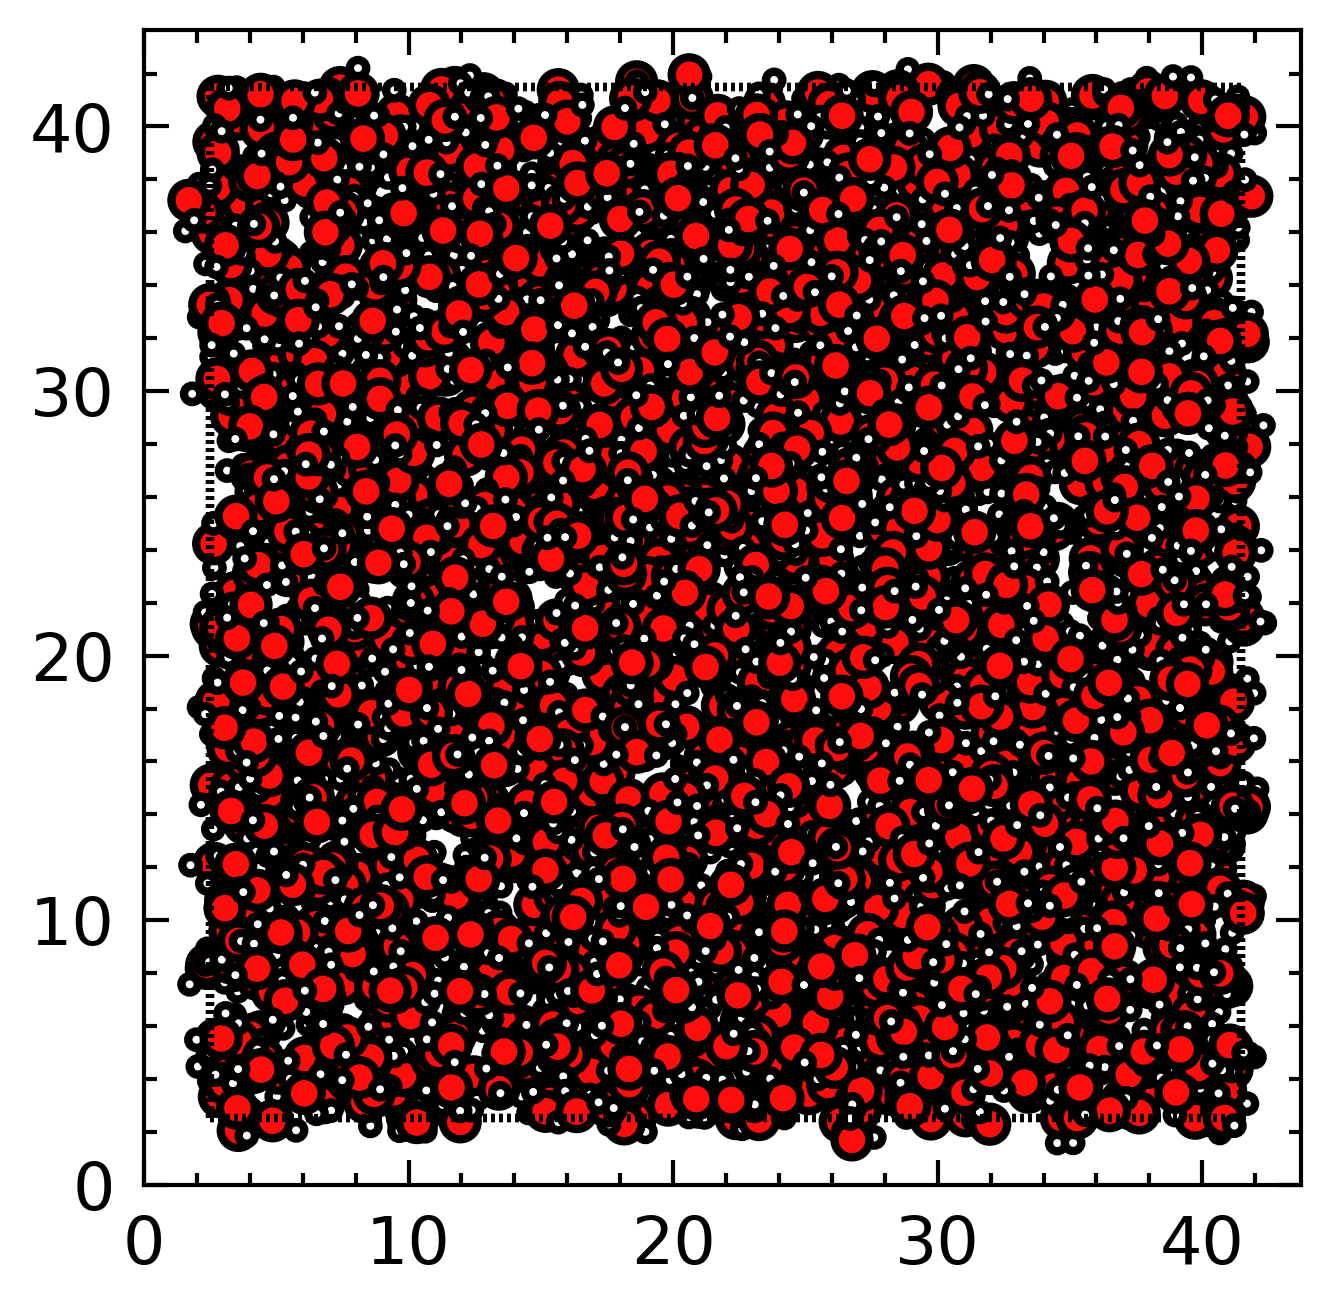

In [275]:
plot_atoms(ATOMS[0])

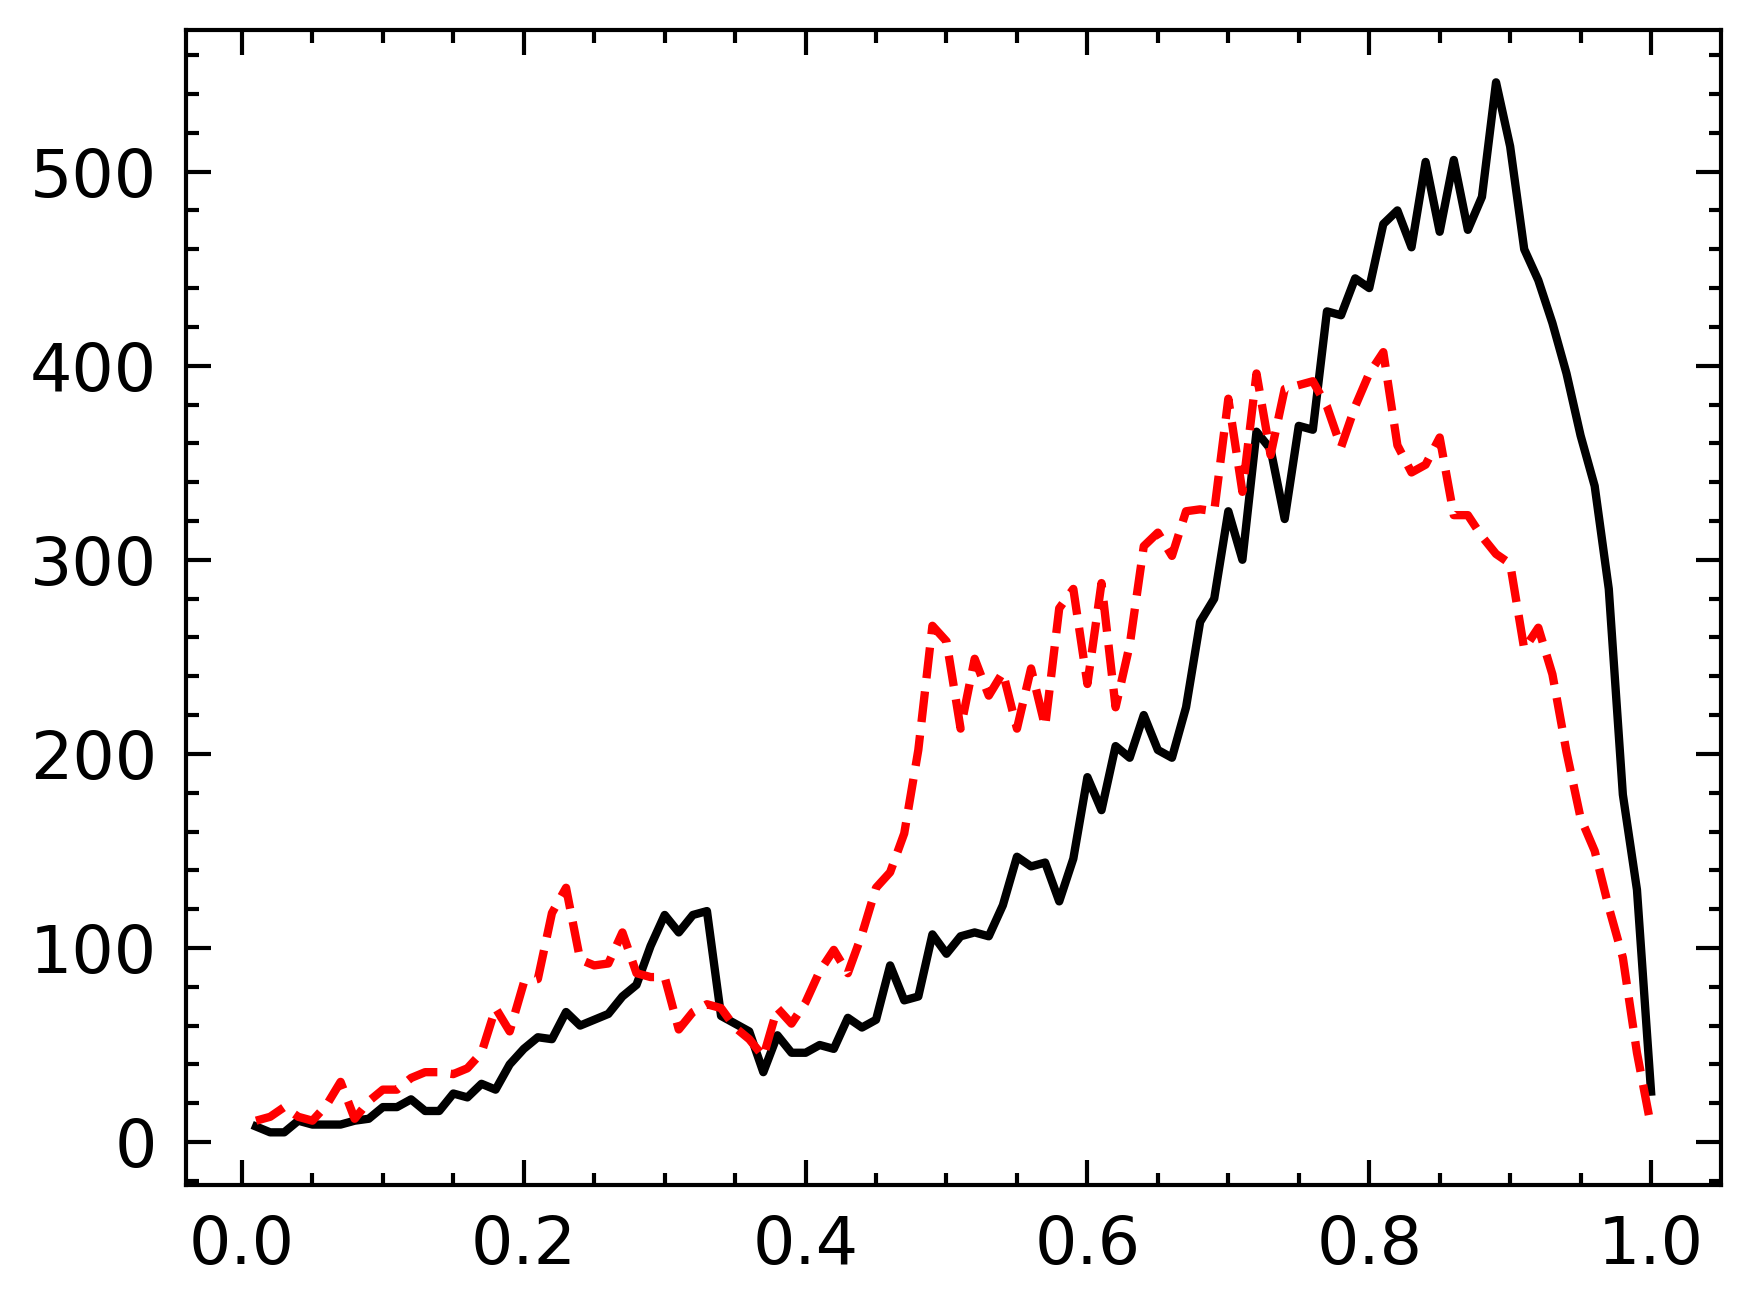

In [97]:
plt.plot(*np.loadtxt("test_oto.dat").T)
plt.plot(*np.loadtxt("shake_comb_oto.dat").T)

In [23]:
FONTSIZE = 16

import matplotlib.pyplot as mpl
import numpy as np
mpl.rcParams['text.latex.preamble'] = [
    r'\usepackage{siunitx}',  # i need upright \micro symbols, but you need...
    r'\sisetup{detect-all}',  # ...this to force siunitx to actually use your fonts
    r'\usepackage{helvet}',  # set the normal font here
    r'\usepackage{sansmath}',  # load up the sansmath so that math -> helvet
    r'\sansmath'  # <- tricky! -- gotta actually tell tex to use!
]

import pylab as plt
params = {'text.usetex': False, 'mathtext.fontset': 'stixsans'}
plt.rcParams.update(params)

In [45]:
import seaborn as sns
# fig, ax = plt.subplots(1,1)

import patchworklib as pw

ax = pw.Brick(figsize=(3, 3))

kmdcm = np.loadtxt("test_oto_raw.dat")
shake = np.loadtxt("shake_comb_oto_raw.dat")
sns.kdeplot(kmdcm,ax=ax, label="kMDCM-RKHS", 
            color="blue", clip= (-1.0, 1.0))
sns.kdeplot(shake, ax=ax, label="TIP3 (SHAKE)", color="orange",
            linestyle="-", clip= (-1.0, 1.0))
ax.axvline(0.8, color="black", linestyle="--", alpha=0.51)
ax.axvline(np.median(kmdcm), color="blue", linestyle="-", alpha=0.51)
ax.axvline(np.median(shake), color="orange", linestyle="-", alpha=0.51)
ax.set_xlabel("$Q$", fontsize=FONTSIZE)
ax.set_ylabel("$P(Q)$", fontsize=FONTSIZE)
ax.set_xlim(-0.5,1)
ax.legend(fontsize=FONTSIZE)

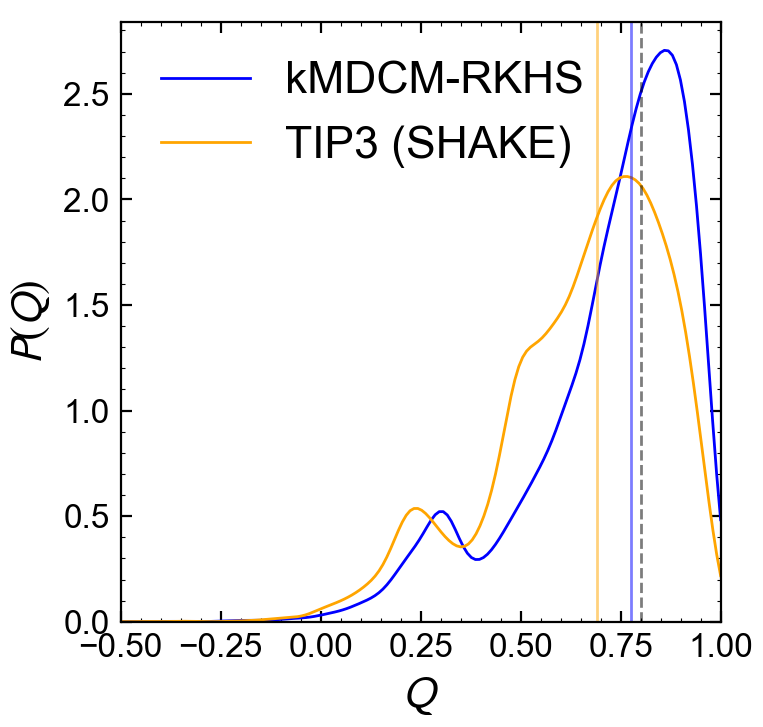

In [46]:
ax

In [26]:
water_rdf_1 = """2.4615076480275357 0.059468174017968334
2.512692313398513 0.3882072509136556
2.5574974407667312 1.423799138515099
2.5603163063958574 1.1114688268079047
2.589246769431628 1.9059735224445984
2.602945467313522 2.388157797130691
2.6548719394290066 2.6347046867350117
2.6890939572422585 2.8429051130266214
2.7816714389567228 2.5853201390640375
2.801551859709508 2.3825695196554055
2.8774634165640496 1.9715690201721972
2.9164824513251135 1.6482599686463002
2.992047831698885 1.2756158232323962
3.1762631732514377 0.8645559792096273
3.4116631801749673 0.7822352120825458
3.717534827826654 0.8916566522756137
4.0769154686487745 1.072281649184752
4.563787961960149 1.1268093902843077
5.197439283117961 0.9182430059987414
5.504695636692729 0.874239029914591
6.099575192004312 0.9615843013911327
6.658353485749892 1.0489493543808615
7.2905706472016565 0.9992878655252708
7.88648873195555 0.971564074793899
8.698618755841729 0.9875574282054682
9.330341379463821 0.992690730877456
10.449431034226963 0.9975569831214215
11.31596021937698 0.9861232684994214
"""

water_rdf_2 = """2.412776412776413 0.03828650785172538
2.515970515970516 0.438436064523021
2.5454545454545454 1.142826621087491
2.633906633906634 1.9951287255635082
2.751842751842752 2.482256169212691
2.86977886977887 2.065035786774917
2.9729729729729732 1.4999679521418652
3.194103194103194 0.9437666915927785
3.385749385749386 0.8483922657835701
3.8574938574938575 0.9882063882063881
4.211302211302211 1.0582843713278498
4.535626535626536 1.0500587544065805
4.88943488943489 1.0157889114410854
5.213759213759214 0.9988676423459031
5.523341523341523 0.9471423993163122
5.803439803439803 0.9388526866787736
6.083538083538084 0.9653455827368871
6.378378378378379 1.0179468005554961
6.658476658476658 1.0444396966136096
6.968058968058967 1.036192714453584
7.616707616707616 1.0110458284371329
8.132678132678132 1.0030979596196985
8.737100737100738 1.0039739344087169
9.533169533169533 0.9964320051276572
9.93120393120393 1.01440017092191
"""


def plot_rdf_exp(ax, shift=0, c="k", lw=0.5, linestyle="--", marker="o"):
    # exp. data
    ex = []
    ey = []
    for _ in water_rdf_1.split("\n"):
        if _:
            ex.append(float(_.split(" ")[0]))
            ey.append(float(_.split(" ")[1]) + shift)

    ax.plot(
        ex,
        ey,
        linestyle,
        fillstyle="none",
        marker=marker,
        c=c,
        alpha=0.5,
        label="Exp. 1",
        linewidth=lw,
    )
    # exp. data
    ex = []
    ey = []
    for _ in water_rdf_2.split("\n"):
        if _:
            ex.append(float(_.split(" ")[0]))
            ey.append(float(_.split(" ")[1]) + shift)

    ax.plot(
        ex,
        ey,
        linestyle,
        fillstyle="none",
        c=c,
        alpha=0.5,
        marker=marker,
        label="Exp. 2",
        linewidth=lw,
    )
    return ax

In [27]:
import numpy as np
import matplotlib.pyplot as plt

with open("/home/boittier/pcbach/kmdcm_water_sim_rkhs1/rdf.dat") as f:
    lines = f.readlines()
    results = [[float(x) for x in _.split()] for _ in lines]
results = np.array(results)

with open("/home/boittier/pcbach/shake/shake-rdf.dat") as f:
    lines = f.readlines()
    Sresults = [[float(x) for x in _.split()] for _ in lines]
Sresults = np.array(Sresults)

In [43]:


ax2 = pw.Brick(figsize=(3,3))


plot_rdf_exp(ax2)
ax2.plot(*results.T, label="kMDCM-RKHS", color="blue", linewidth=0.75)
ax2.plot(*Sresults.T, label="TIP3 (SHAKE)", alpha=1, 
        color="orange", linestyle="-", linewidth=0.75)
ax2.legend(fontsize=FONTSIZE)
ax2.set_ylabel("$g(r)$", fontsize=FONTSIZE)
ax2.set_xlabel("$r~[Å]$", fontsize=FONTSIZE)
# plt.savefig("rdf_.pdf", bbox_inches="tight")
ax2.set_xlim(0,10)
ax2.set_ylim(0,3)
ax2.axhline(1, color="k", alpha=0.1)
# plt.savefig("kmdcm-rdf-231129.pdf", bbox_inches="tight")

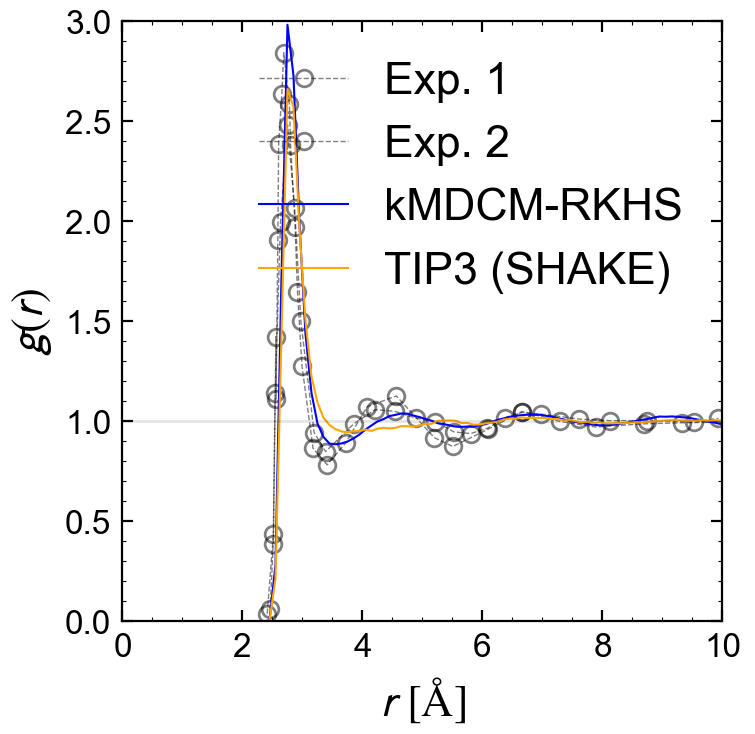

In [44]:
ax2

In [30]:
import pandas as pd


ax3 = pw.Brick(figsize=(3,3))

xs = []
ys = []
with open("/home/boittier/Downloads/waterIR.jdx") as f:
    lines = f.readlines()[37:-2]
    for line in lines:
        x, y = [float(_) for _ in line.split()][:2]
        xs.append(x)
        ys.append(1 - y)
water_exp_spectrum = [xs, ys]

_df = pd.read_csv("/home/boittier/Documents/phd/waterNN/MDCM-nn.csv")
_df["Computed"] = _df["spectra"] * 0.35

_df.rolling(50).mean().plot("freq", "Computed", ax=ax3, color="blue", 
                            label="kMDCM-RKHS")

ax3.set_xlim(0, 4000)
ax3.plot(water_exp_spectrum[0], 
         np.array(water_exp_spectrum[1])*0.5, label="Exp.", color="k")
ax3.set_xlim(1000,4000)
ax3.legend(fontsize=FONTSIZE, loc="upper left")
ax3.set_ylim(0,0.65)
ax3.set_xlabel("Freq [cm$^{-1}$]", fontsize=FONTSIZE)
ax3.set_ylabel("Intensity [Arb.]", fontsize=FONTSIZE)
# plt.savefig("IR.pdf", bbox_inches="tight")

Text(-205.79166666666666, 0.5, 'Intensity [Arb.]')

In [31]:
import matplotlib

# plt.rcParams['text.usetex'] = False
# plt.rcParams['mathtext.fontset'] = 'stix'
# matplotlib.rc('text', usetex = False)

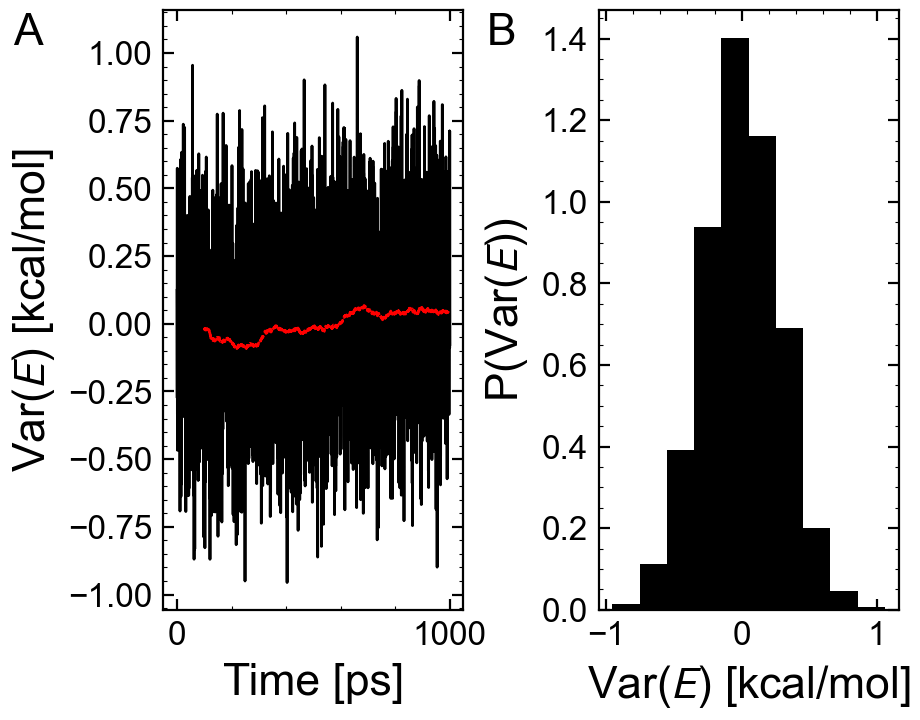

In [33]:
ax_md1 = pw.Brick(figsize=(1.5, 3))
ax_md2 = pw.Brick(figsize=(1.5, 3))

vals = cl["tot"].iloc[-1000000:].dropna() 
# vals = cl["tot"].iloc[200:600].dropna() 

(vals - vals.mean()).plot(ax=ax_md1)
(vals - vals.mean()).rolling(500).mean().plot(ax=ax_md1)
ax_md1.set_xticks([0, 5000], [0, 1000])
ax_md2.hist((vals - vals.mean()), density=True)
# .hist(ax=ax_md2)
ax_md1.set_xlabel("Time [ps]", fontsize=FONTSIZE)
ax_md1.set_ylabel("Var($E$) [kcal/mol]", fontsize=FONTSIZE)
ax_md2.set_ylabel("P(Var($E$))", fontsize=FONTSIZE)
ax_md2.set_xlabel("Var($E$) [kcal/mol]", fontsize=FONTSIZE)

ax_md1.set_index("A", fontsize=16, x=0,y=0.95)
ax_md2.set_index("B", fontsize=16, x=0,y=0.95)

md_cons = pw.stack([ax_md1 , ax_md2], operator="|", margin=0)
md_cons

In [50]:
ax2.set_index("D", fontsize=16, x=0,y=0.95)
ax.set_index("E", fontsize=16, x=0,y=0.95)
ax3.set_index("C", fontsize=16, x=0,y=0.95)

line1 = pw.stack([ax2 , ax], operator="|", margin=0)
line2 = pw.stack([ md_cons,ax3  ] , operator="|", margin=0)

In [51]:
final = pw.stack([ line2, line1], operator="/", margin=0.2)

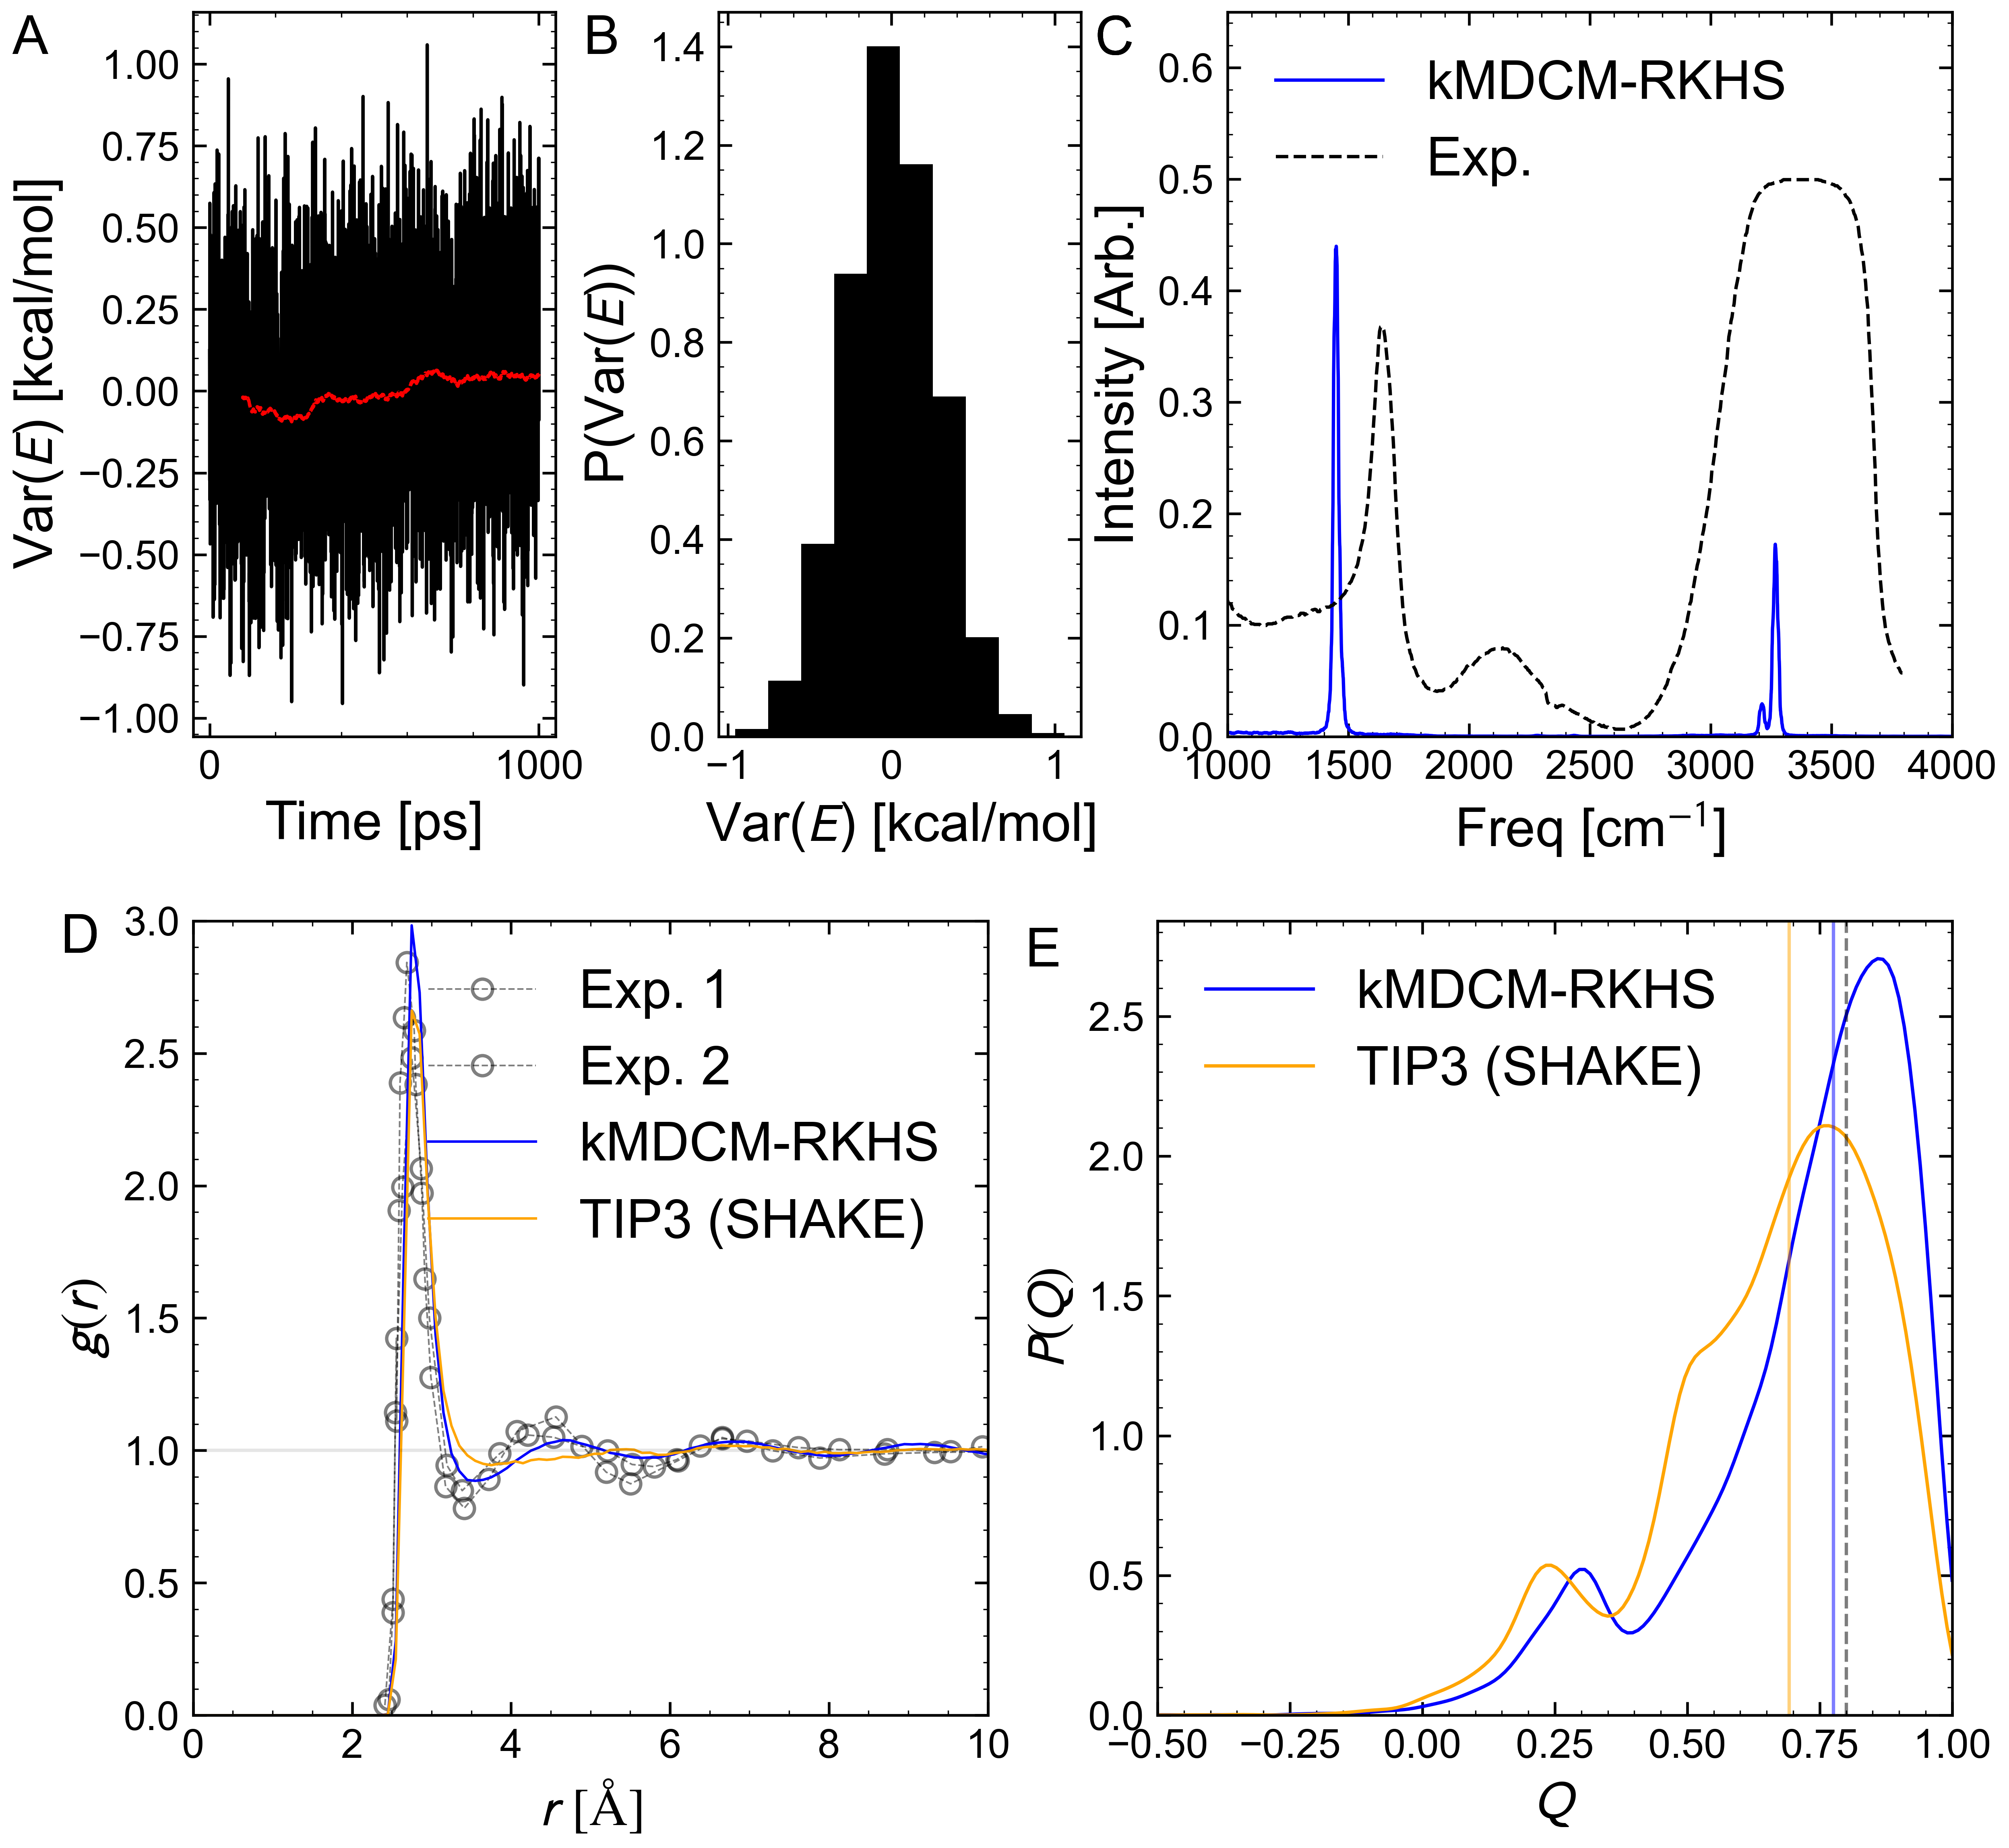

In [52]:
final.savefig("md_fig.pdf")